In [1]:
## IMPORT MODULES
%pylab inline
import os
import healpy
import polyspec as ps
import camb

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


### Introduction

In this tutorial we demonstrate how to use the ```PolySpec``` code to compute the amplitudes of primordial and late-time trispectra, such as local and lensing non-Gaussianity. PolySpec can also be used to estimate binned power spectra, bispectra and trispectra -- details of this are provided in the other tutorial. Below, we'll run ```PolySpec``` on some small toy problems. In practice, we would use much larger $N_{\rm side}$ and $\ell_{\rm max}$, and likely run the code on a high-performance cluster.

# 1. Set-up

### General Settings

In [2]:
# HEALPix settings
Nside = 256 # choosing a very low value for fast Bl & Tl - usually larger!

# Which code to use for harmonic transforms ["healpix" or "ducc"] 
# ducc is ~ 2x faster but needs to be installed before use
backend = 'ducc'

# Number of CPUs to use for multiprocessing (use as many as possible!)
N_cpus = 4

# Whether to include bins only partially satisfying triangle conditions
include_partial_triangles = False

# Galactic Mask
# Here, we'll use the common intensity/polarization component-separation mask for testing
root = '/mnt/home/ophilcox/ceph/planck_npipe/'
maskfileT = 'COM_Mask_CMB-common-Mask-Int_2048_R3.00.fits'
maskfileP = 'COM_Mask_CMB-common-Mask-Pol_2048_R3.00.fits'

# Whether to include polarization (i.e. E+B)
pol = True

### Fiducial Power and Noise Spectra
Below, we define a fiducial power and noise spectrum that we'll use to generate the testing simulations, and to weight the data. Here, we'll use compute this using CAMB, assuming the Planck 2018 cosmology. We generate all possible two-point functions: $TT,TE,TB,EE,EB,BB$. If we're not running in polarization mode, we just need $TT$ here. Since we are using the lensing estimator, we also compute $C_\ell^{\phi\phi}$. For simplicity, we'll ignore any instrument beam (except in the noise spectrum).

In [3]:
# Fiducial cosmological parameters
H0, ombh2, omch2, tau, ns, deltaR2, mnu = 67.32117, 0.0223828, 0.1201075, 0.05430842, 0.9660499, 2.100549e-9, 0.06

# Set-up CAMB
pars = camb.CAMBparams()
pars.set_cosmology(H0=H0, ombh2=ombh2, omch2=omch2, tau=tau, num_massive_neutrinos=1, mnu=mnu)
pars.InitPower.set_params(As=deltaR2, ns=ns, r=0, nt=0)
pars.AccurateBB=True
pars.AccuratePolarization=True
pars.DoLensing = True
pars.set_for_lmax(6*Nside, lens_potential_accuracy=1, lens_margin=0, nonlinear=True, k_eta_fac=2.5);

# Compute lensed power spectra, including the power spectrum of the lensing potential
results = camb.get_results(pars);
all_spectra = results.get_cmb_power_spectra(pars,raw_cl=True,CMB_unit='K')
clTT,clEE,clBB,clTE = all_spectra['lensed_scalar'].T
clpp = all_spectra['lens_potential'][:,0]

In [4]:
# Define ell arrays
l = np.arange(3*Nside)

# Compute dictionary of signal C_ell
Cl_th = {}
if pol:
    Cl_th = {}
    Cl_th['TT'] = clTT[:len(l)]
    Cl_th['TE'] = clTE[:len(l)]
    Cl_th['EE'] = clEE[:len(l)]
    Cl_th['BB'] = clBB[:len(l)]
    Cl_th['TB'] = Cl_th['EB'] = 0.*clTT[:len(l)] # set to zero!
else:
    Cl_th['TT'] = clTT[:len(l)]
    
# Compute noise C_ell, including the beam factor
DeltaT = 60./60.*np.pi/180.*1e-6 # in K-radians
DeltaP = 60./60.*np.pi/180.*1e-6*np.sqrt(2) 
thetaFWHM = 5./60.*np.pi/180. # in radians
NlT = DeltaT**2*np.exp(l*(l+1)*thetaFWHM**2/(8.*np.log(2)))*(l>=2)
NlP = DeltaP**2*np.exp(l*(l+1)*thetaFWHM**2/(8.*np.log(2)))*(l>=2)
Nl_th = {}
if pol:
    Nl_th['TT'] = NlT
    Nl_th['TE'] = Nl_th['TB'] = Nl_th['EB'] = 0.*NlT
    Nl_th['EE'] = Nl_th['BB'] = NlP
else:
    Nl_th['TT'] = NlT

Let's plot the spectra:

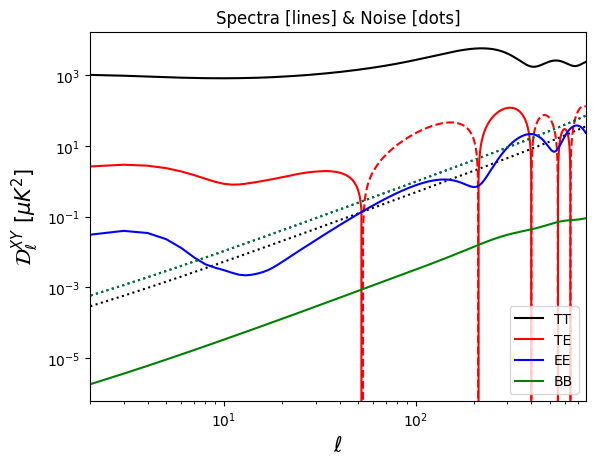

In [5]:
cols = ['k','r','b','g','purple','pink']
for i,f in enumerate(list(Cl_th.keys())):
    if np.sum(Cl_th[f]+Nl_th[f])==0: continue
    plt.plot(l,l*(l+1)/(2*np.pi)*Cl_th[f]*1e12,label=f,c=cols[i])
    plt.plot(l,-l*(l+1)/(2*np.pi)*Cl_th[f]*1e12,c=cols[i],ls='--')
    plt.plot(l,l*(l+1)/(2.*np.pi)*Nl_th[f]*1e12,c=cols[i],ls=':')
if pol:
    plt.xscale('log')
    plt.yscale('log')
else:
    plt.ylim([0,6200])
plt.legend()
plt.xlim([2,3*Nside])
plt.ylabel(r'$\mathcal{D}_\ell^{XY}$ [$\mu K^2$]',fontsize=15)
plt.xlabel(r'$\ell$',fontsize=15)
plt.title("Spectra [lines] & Noise [dots]");

### Load mask
For testing, we use the *Planck* common component-separation sky masks with 2-degree apodization applied.

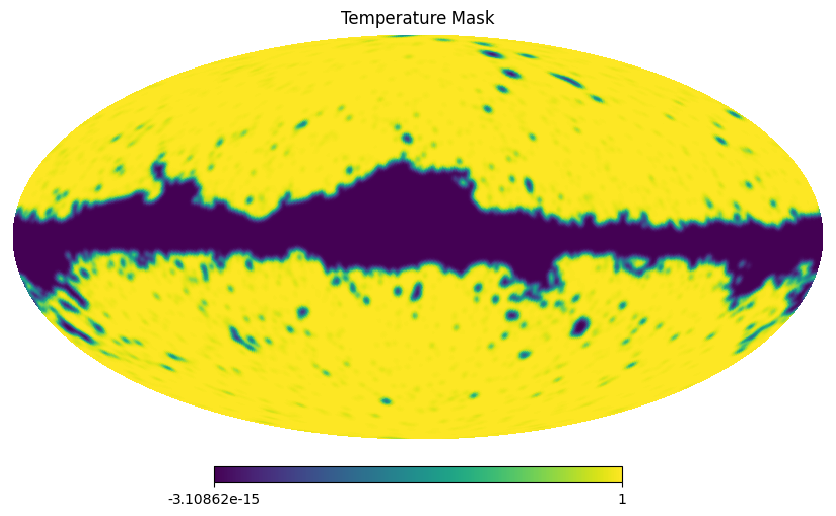

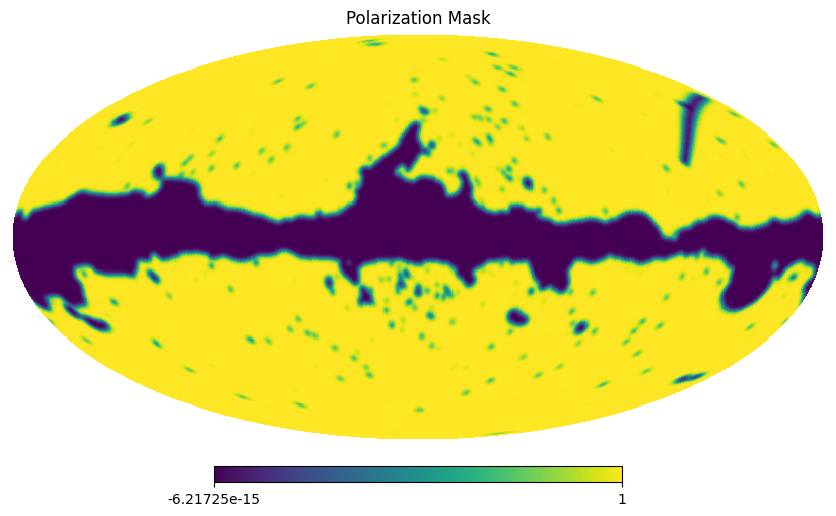

In [6]:
if not os.path.exists(root+maskfileT):
    os.system(r"wget -O {root+maskfileT} https://irsa.ipac.caltech.edu/data/Planck/release_3/ancillary-data/masks/COM_Mask_CMB-common-Mask-Int_2048_R3.00.fits")
if pol and not os.path.exists(root+maskfileP):
    os.system(r"wget -O {root+maskfileP} https://irsa.ipac.caltech.edu/data/Planck/release_3/ancillary-data/masks/COM_Mask_CMB-common-Mask-Pol_2048_R3.00.fits")

if pol:
    # Load and smooth masks
    maskT = healpy.smoothing(healpy.ud_grade(healpy.read_map(root+maskfileT,field=0),Nside),2*np.pi/180.)
    maskP = healpy.smoothing(healpy.ud_grade(healpy.read_map(root+maskfileP,field=0),Nside),2*np.pi/180.)
    # Define a combined mask vector for T,Q,U
    mask = np.array([maskT,maskP,maskP])
else:
    # Load and smooth masks
    mask = healpy.smoothing(healpy.ud_grade(healpy.read_map(root+maskfileT,field=0),Nside),2*np.pi/180.)[None]

healpy.mollview(mask[0],title='Temperature Mask')
if pol:
    healpy.mollview(mask[1],title='Polarization Mask')

### Initialize the PolySpec class

Let's start by calling the main PolySpec class. This contains a bunch of useful methods, including spherical harmonic transforms (via HEALPix or DUCC, depending on our choice of backend) and code to generate random simulations. We can also include the experimental beam here. (Note that the input data should *not* be beam-deconvolved -- this is performed in the weighting step). We can either run the code in polarization mode (`pol=True`) or scalar mode (`pol=False`). In the latter case, we only need to feed in temperature spectra.

In [7]:
## Define fiducial beam and signal+noise
# Note that the beam should include a pixel-window function if present in the data
if not pol:
    beam = [1.+0.*l]
else:
    beam = [1.+0.*l, 1.+0.*l] # Temperature and polarization
Cl_fiducial = {}
for f in Cl_th.keys(): Cl_fiducial[f] = beam[0]**2*Cl_th[f]+Nl_th[f]

# Define class, optionally including polarization
base = ps.PolySpec(Nside, Cl_fiducial, beam=beam, pol=pol, backend=backend, nthreads=N_cpus)

Next, we'll create some synthetic data with a known $C_\ell^{XY}$. We then mask this data with the *Planck* map. 

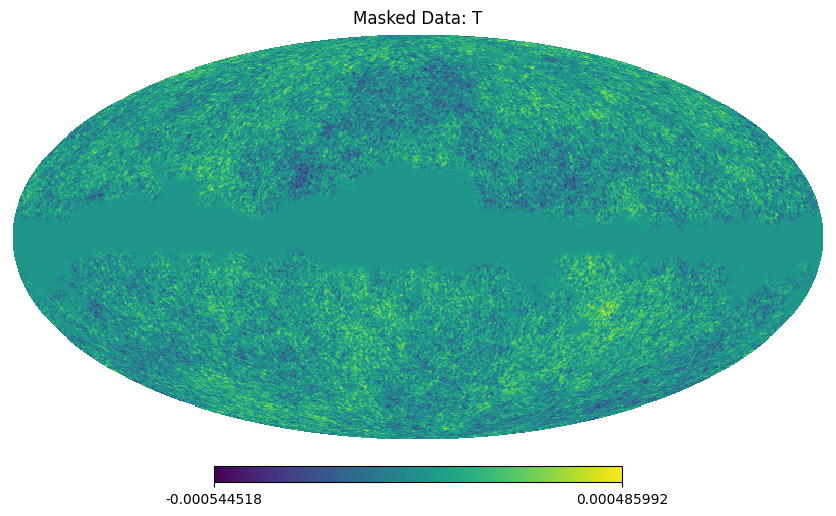

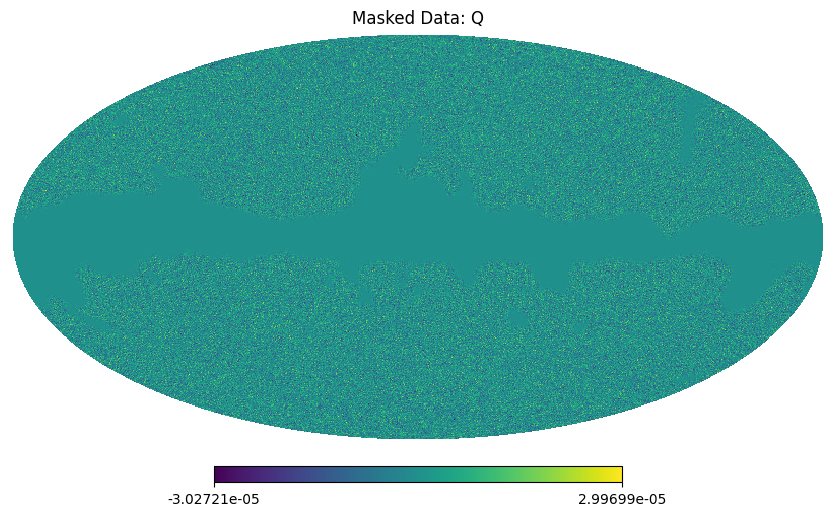

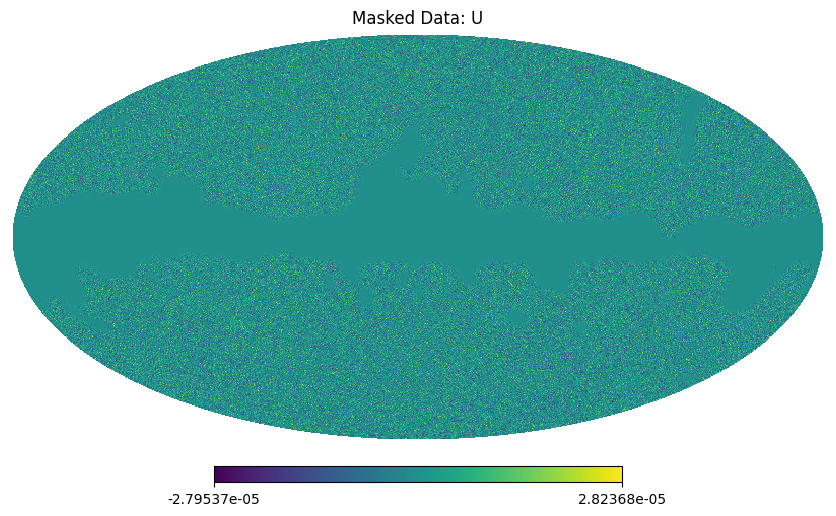

In [8]:
# Generate unmasked data with known C_l
# Cl^XY are set to the fiducial spectrum (which includes the beam) unless otherwise specified
raw_data = base.generate_data(seed=42)

# Mask the map
data = (raw_data*mask).reshape(len(raw_data),-1)

# Plot the data
labels = ['T','Q','U']
for i in range(len(data)):
    healpy.mollview(data[i],title='Masked Data: %s'%labels[i])

### Define weighting function
A crucial input to the unwindowed estimators is a function, $\mathsf{S}^{-1}$, which provides quasi-optimal weighting to the data. For an optimal estimator, $\mathsf{S}^{-1}=\mathsf{P}^\dagger\mathsf{C}^{-1}$, where $\mathsf{P}$ is the pointing matrix (including the beam and mask) and $\mathsf{C}^{-1}$ is the true pixel covariance (which includes noise and the beam). In the absence of a mask, the optimal $\mathsf{S}^{-1}$ is given by $C^{\mathrm{tot},-1}_\ell\times \mathsf{B}^{-1}$, where $C^{\rm tot}_{\ell}$ is the total (signal+noise+beam) power spectrum and $\mathsf{B}$ is the beam. In the presence of holes in the mask, the optimal weighting is non-trivial to implement, and we usually use an approximation (which does not lead to bias). 

In the ```polyspec.Weightings``` class, we implement two weighting schemes. 
- ```applySinv_ideal```: We (optionally) apply diffusive inpainting, then divide the data by $C^{\rm tot}_\ell/B_\ell$ in harmonic space.
- ```applySinv_optimal```: We implement the optimal weighting scheme using a conjugate gradient descent algorithm. This allows for spatially varying Poisson noise, but does not account for scale-dependence.
In practice, the idealized weighting is far cheaper and usually leads to close-to-optimal errors. Any other weighting scheme can be simply implemented by defining a new ```Sinv``` function, with the same structure as ```applySinv_ideal```.

In [9]:
# Define some mock pixel-space noise covariance
# This is only needed if we use the optimal S^-1 weighting
noise_cov = np.ones_like(data)*np.asarray([DeltaT**2, DeltaP**2, DeltaP**2])[:1+2*pol,None]/(4.*np.pi)*healpy.nside2npix(Nside)

# Define weighting class including theoretical Cl spectra
weightings = ps.Weightings(base, mask, Cl_th, noise_cov=noise_cov, inpainting_mask=None)

# Define ideal S^-1 operator
Sinv_ideal = weightings.applySinv_ideal

# Define optimal S^-1 operator, including conjugate-gradient-descent inversion
Sinv_opt = weightings.applySinv_optimal

Let's compute and plot the weighted maps. We'll transform to pixel-space and add a factor of $C_\ell$, to obtain the Wiener-filtered solution.

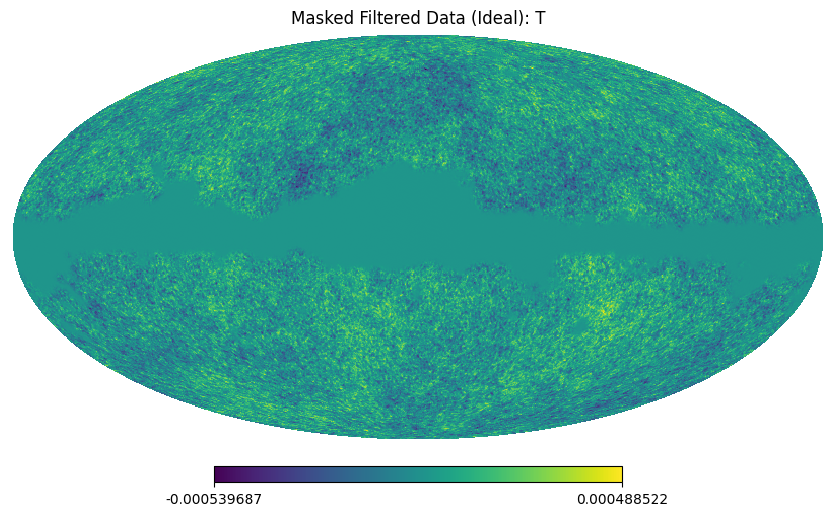

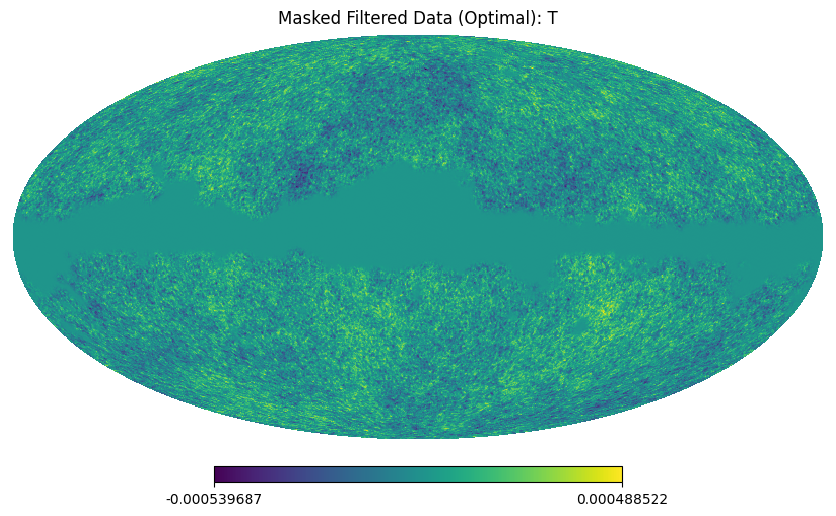

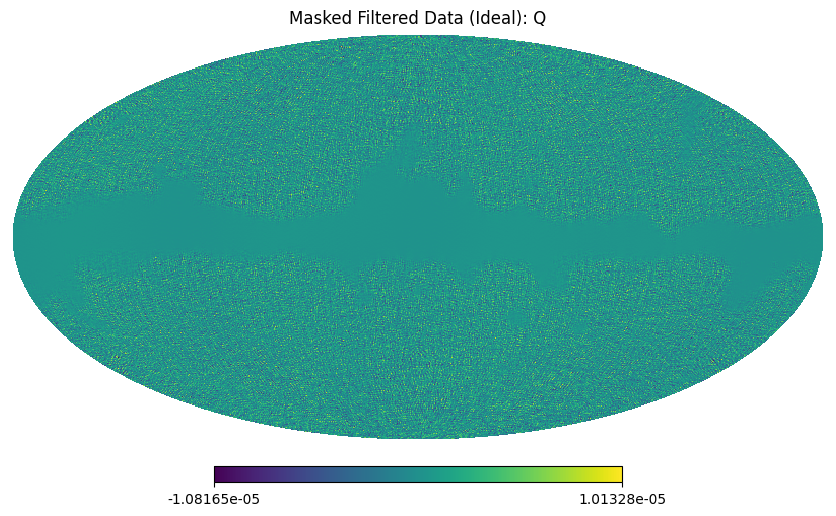

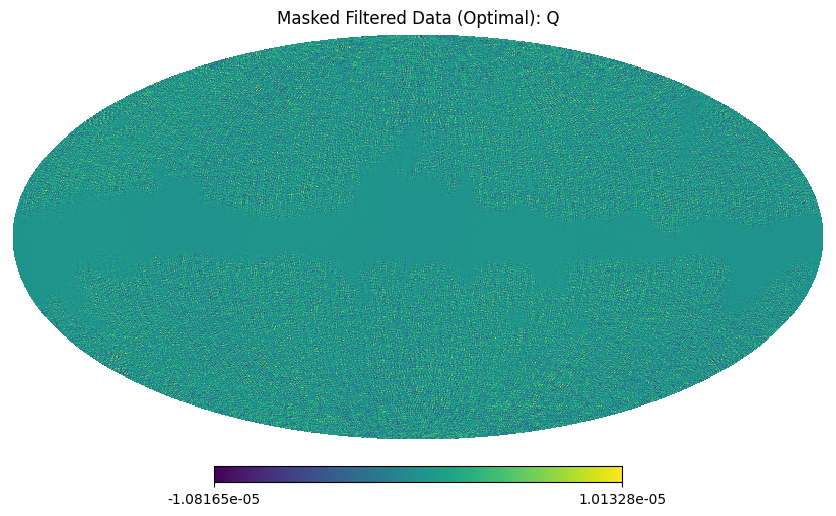

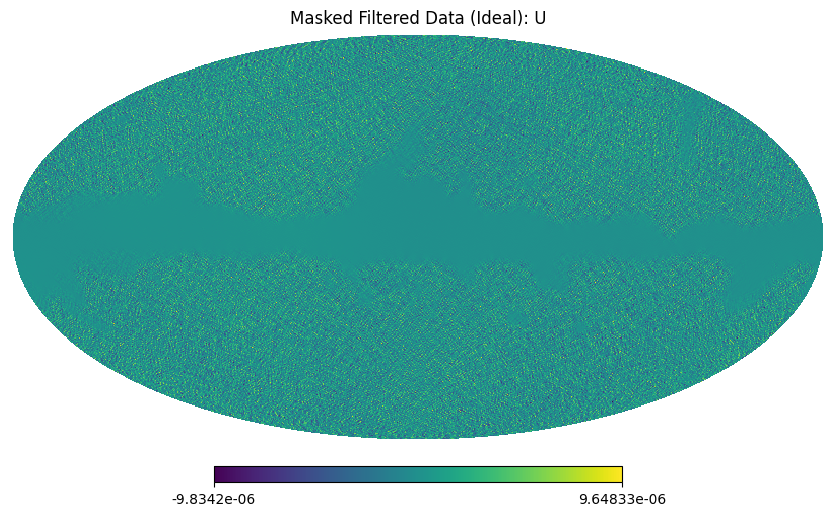

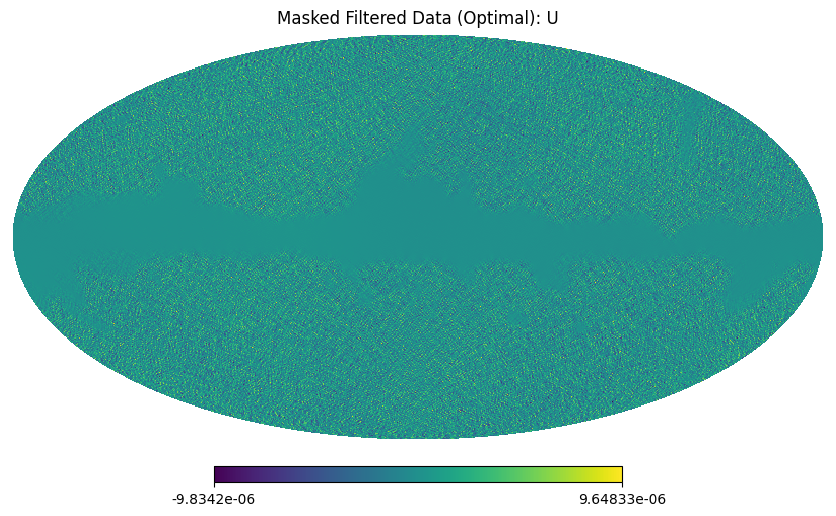

In [10]:
# Compute Wiener  the map
Sinv_data_ideal = base.to_map(np.einsum('lab,bl->al',weightings.Cl_lm_mat,Sinv_ideal(data)))
Sinv_data_opt = base.to_map(np.einsum('lab,bl->al',weightings.Cl_lm_mat,Sinv_ideal(data)))

# Plot the data
labels = ['T','Q','U']
for i in range(len(Sinv_data_ideal)):
    healpy.mollview(Sinv_data_ideal[i],title='Masked Filtered Data (Ideal): %s'%labels[i])
    healpy.mollview(Sinv_data_opt[i],title='Masked Filtered Data (Optimal): %s'%labels[i])

### Transfer Function
To relate the CMB to the primordial curvature fluctuation, we require the CMB transfer functions $\mathcal{T}_\ell$. Here, we demonstrate how to compute these at high precision using CAMB (also possible using CLASS). Note that these include the CMB temperature.

In [11]:
transfer_file = 'camb_transfer_planck.npz'
if not os.path.exists(root+transfer_file):
    print("Computing transfer functions...")
    
    # Transfer function settings
    pars.DoLensing = True
    pars.BessIntBoost = 30
    pars.KmaxBoost=3
    pars.IntTolBoost=4
    pars.TimeStepBoost=5
    pars.SourcekAccuracyBoost=5
    pars.BesselBoost=5
    pars.IntkAccuracyBoost=5
    pars.AccurateBB=True
    pars.AccurateReionization=True
    pars.AccuratePolarization=True
    pars.set_accuracy(DoLateRadTruncation=False,AccuracyBoost=2,lSampleBoost=50,lAccuracyBoost=2);

    # Compute transfer functions and spectra    
    results = camb.get_results(pars);
    trans = results.get_cmb_transfer_data('scalar')
    ls, qs, DeltasT = trans.get_transfer(source=0)
    ls, qs, DeltasE = trans.get_transfer(source=1)

    # Rescale E mode amplitude for output (usually done later in camb)
    ls = ls.astype(int)
    prefactorE = np.sqrt((ls + 2) * (ls + 1) * ls * (ls - 1))
    DeltasE *= prefactorE[:,None]

    # Save transfer functions
    np.savez(root+transfer_file,l=ls,k=qs,transfer=np.asarray([DeltasT,DeltasE]))

# Load transfer functions
with np.load(root+transfer_file,allow_pickle=True) as transfer_inp:
    print("Loading transfer functions...")
    k_arr = transfer_inp['k']
    if pol:
        # Convert to K units and add ell=0,1 modes
        TlT_k_arr = np.vstack([[np.zeros_like(k_arr) for _ in range(2)],transfer_inp['transfer'][0,:3*Nside]*pars.TCMB])
        TlE_k_arr = np.vstack([[np.zeros_like(k_arr) for _ in range(2)],transfer_inp['transfer'][1,:3*Nside]*pars.TCMB])
        Tl_arr = [TlT_k_arr, TlE_k_arr]
    else:
        # Convert to K units and add ell=0,1 modes
        TlT_k_arr = np.vstack([[np.zeros_like(k_arr) for _ in range(2)],transfer_inp['transfer'][0,:3*Nside]*pars.TCMB])
        Tl_arr = [TlT_k_arr]

Loading transfer functions...


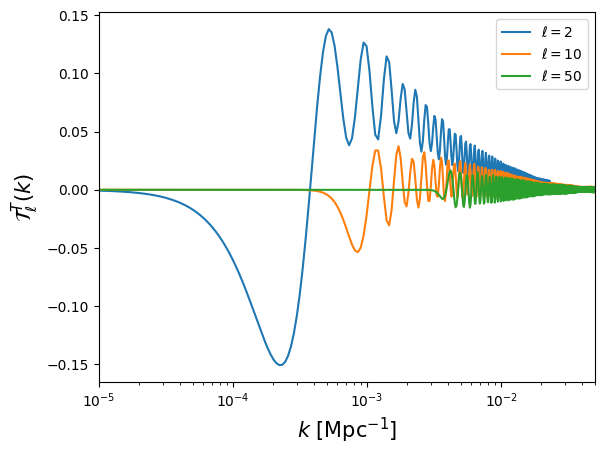

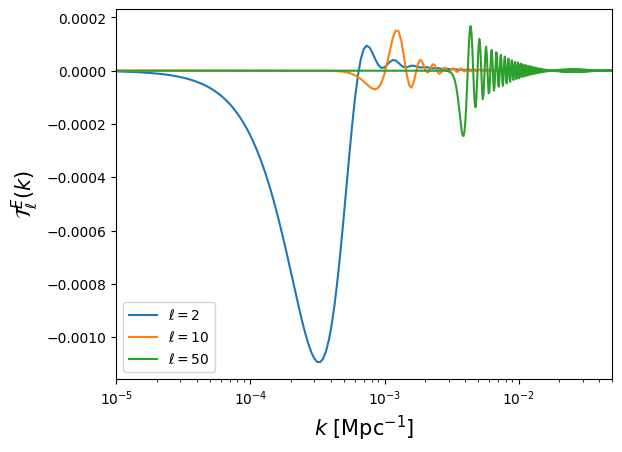

In [12]:
## Plot the transfer functions:
plt.plot(k_arr,Tl_arr[0][2],label=r'$\ell=2$')
plt.plot(k_arr,Tl_arr[0][10],label=r'$\ell=10$')
plt.plot(k_arr,Tl_arr[0][50],label=r'$\ell=50$')
plt.xscale('log')
plt.xlabel(r'$k$ [$\mathrm{Mpc}^{-1}$]',fontsize=15)
plt.ylabel(r'$\mathcal{T}^T_\ell(k)$',fontsize=15)
plt.legend();
plt.xlim(1e-5,5e-2);

if pol:
    plt.figure()
    plt.plot(k_arr,Tl_arr[1][2],label=r'$\ell=2$')
    plt.plot(k_arr,Tl_arr[1][10],label=r'$\ell=10$')
    plt.plot(k_arr,Tl_arr[1][50],label=r'$\ell=50$')
    plt.xscale('log')
    plt.xlabel(r'$k$ [$\mathrm{Mpc}^{-1}$]',fontsize=15)
    plt.ylabel(r'$\mathcal{T}^E_\ell(k)$',fontsize=15)
    plt.legend();
    plt.xlim(1e-5,5e-2);

# 2. Template Estimation

PolySpec can be used to estimate the amplitudes of thirteen types of trispectrum template:
- `gNL-loc`,`tauNL-loc`: Local non-Gaussianity, $g_{\rm NL}^{\rm loc}$ and $\tau_{\rm NL}^{\rm loc}$.
- `gNL-con`: Constant, scale-independent non-Gaussianity, $g_{\rm NL}^{\rm con}$.
- `gNL-dotdot`, `gNL-dotdel`, `gNL-deldel`: Effective Field Theory of Inflation non-Gaussianity, $g_{\rm NL}^{\dot\sigma^4},g_{\rm NL}^{\dot{\sigma}^2(\partial\sigma)^2},g_{\rm NL}^{(\partial\sigma)^4}$.
- `tauNL-even:n`, `tauNL-odd:n`, `tauNL-direc:n1,n3,n`: Direction-dependent non-Gaussianity, $\tau_{\rm NL}^{n,\rm even}$, $\tau_{\rm NL}^{n,\rm odd}$, $\tau_{\rm NL}^{n_1n_3n}$. This is specified by integers $n_1,n_3,n$ (e.g., `tauNL-even:2` is $\tau_{\rm NL}^{2,\rm even}$).
- `tauNL-light:s,nu`, `tauNL-heavy:s,mu`L Massive particle exchange non-Gaussianity, $\tau_{\rm NL}^{\rm light}(s,\nu_s)$, $\tau_{\rm NL}^{\rm heavy}(s,\mu_s)$. This depends on an integer spin, $s$, and a mass parameter $\nu_s$ or $\mu_s$.
- `lensing`: Weak gravitational lensing. The code estimates the overall amplitude $A_{\rm lens}$.
- `point-source`: Non-Gaussianity from unclustered and unpolarized point sources, $t_{\rm ps}$.

There are three main steps to the estimator:

1.  **Optimization**: Generate an optimized set of integration points and weights (see the papers for more details). This isn't needed if we're just analyzing lensing or point-sources.
2.  **Numerator**: Apply the quartic estimator to a dataset. 
3.  **Normalization**: Compute the mask- and beam-dependent Fisher matrix used to normalize and decorrelate the estimators.

In practice, all of these steps should be performed on a high-performance computing node -- for demonstration, we'll pick a low-dimensional problem (with low $\ell_{\rm max}$) that can be computed quickly. We'll consider three templates: $g_{\rm NL}^{\rm loc}$, $\tau_{\rm NL}^{\rm loc}$, and $A_{\rm lens}$. 


First, we'll define a few extra settings:

In [13]:
## Templates to analyze (from above list)
templates = ['gNL-loc','tauNL-loc','lensing']

## Scale-cuts
lmin, lmax = 2, 500 # external leg
Lmin, Lmax = 2, 30 # internal leg
Lmin_lens, Lmax_lens = 2, 500 # lensing estimator

## Monte Carlo parameters
N_fish = 10 # number of Monte Carlo realizations used to estimate the Fisher matrix (typically 10-20)
N_disc = 50 # number of simulations used to subtract disconnected contributions from the estimators (typically 50-100)

## Analysis settings
N_sim = 25 # number of simulations to analyze

## Optimization settings
reduce_r = 2 # this scales the number of radial integration points before optimization. Setting reduce_r = 1 or 2 is normally appropriate.
optim_thresh = 1e-3 # tolerance for the optimization algorithm. Typically 10^-3 or 10^-4
N_fish_optim = 1 # number of Monte Carlo iterations used to compute the high-resolution tauNL Fisher matrix. Typically 1 or a few. 

Next, we initialize the `TSpecTemplate` code. This requires various options, most of which are self-explanatory.

In [14]:
tspec = ps.TSpecTemplate(base, 
                         # Basic analysis settings
                         mask, Sinv_ideal, templates, k_arr, Tl_arr, 
                         # Scale-cuts
                         lmin, lmax, Lmin=Lmin, Lmax=Lmax, Lmin_lens=Lmin_lens, Lmax_lens=Lmax_lens,
                         # Cosmological parameters
                         k_pivot=pars.InitPower.pivot_scalar, ns = pars.InitPower.ns, As = pars.InitPower.As, 
                         # Lensing power spectra (only needed if computing lensing)
                         C_phi = clpp, C_lens_weight = {'TT':clTT,'TE':clTE,'EE':clEE,'BB':clBB})

Primordial Spectrum: n_s = 0.966, A_s = 2.101e-09, k_pivot = 0.050
l-range: [2, 500]
L-range: [2, 30]
Lensing L-range: [2, 500]
Polarizations: ['T', 'E']
Templates: ['gNL-loc', 'tauNL-loc', 'lensing']
Mask: spatially varying
# No input radial sampling points supplied; these can be computed with the optimize_radial_sampling_1d() function



## a) Optimization

The first step is to run the optimization algorithm. This first computes the Fisher matrix at high-resolution, then uses an optimization algorithm to find a low-dimensional representation of the matrix that can be used in subsequent computations. This uses the `optimize_radial_sampling_1d` routine, or if analyzing the Effective Field Theory shapes, `optimize_radial_sampling_2d`. Depending on the input parameters and $\ell_{\rm max}$, this might take a few minutes to run.

In [15]:
# Run optimization
radial_samples, radial_weights = tspec.optimize_radial_sampling_1d(reduce_r=reduce_r, tolerance=optim_thresh, N_fish_optim=N_fish_optim, verb=True)

# Save the ideal Fisher matrix for later!
ideal_fisher = tspec.ideal_fisher

# Computing k integrals with fiducial radial grid
N_k: 3400
N_r: 343

Precomputing Bessel functions
Interpolating Bessel functions
Computing p_lL^X(r) integrals
Computing q_l^X(r) integrals
Computing F_LL'(r, r') integrals
Remove commented pieces and test functions!
Precomputation complete
Computing all Fisher matrix derivatives
	Computing gNL-loc Fisher matrix derivative exactly

Computing Fisher matrix derivatives from realization 1 of 1
Creating Q maps
Creating P_{n,mu} maps
Computing tauNL-loc Fisher matrix derivative

Running optimization for template tauNL-loc
Initial score: 5.37e-08
Iteration 1, trial 0, relative score: 7.24e-01, old score: 1.00e+00
Iteration 2, trial 0, relative score: 2.05e-01, old score: 7.24e-01
Iteration 3, trial 0, relative score: 1.55e-01, old score: 2.05e-01
Iteration 4, trial 0, relative score: 3.21e-02, old score: 1.55e-01
Iteration 5, trial 0, relative score: 1.20e-02, old score: 3.21e-02
Iteration 6, trial 0, relative score: 7.20e-03, old score: 1.20

In this example, the code has optimized the 343 radial integration points down to just 16. This will speed up the analyses below by around $20\times$. Below, we plot the optimized radial points (red) in comparison to the inputs (blue), with size indicating their relative weights in a $g_{\rm NL}^{\rm loc}$ analysis. As expected, they cluster around the distance to last scattering, $r_\star$.

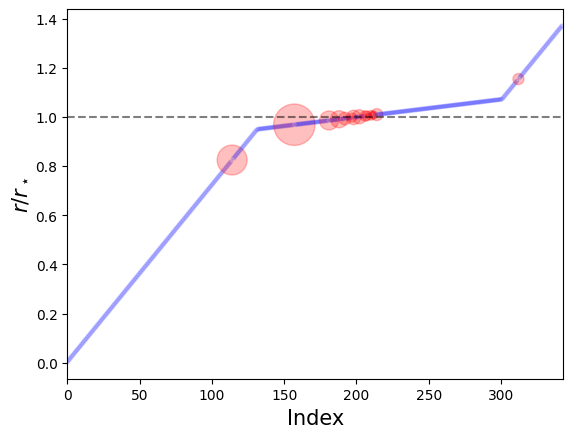

In [16]:
# Compute the starting array (usually done internally in PolySpec)
r_raw = np.asarray(list(np.arange(1,tspec.r_star*0.95,50*reduce_r))+list(np.arange(tspec.r_star*0.95,tspec.r_hor*1.05,5*reduce_r))+list(np.arange(tspec.r_hor*1.05,tspec.r_hor+5000,50*reduce_r)))
r_init = 0.5*(r_raw[1:]+r_raw[:-1])
weights_init = r_init**2*np.diff(r_raw)

# Plot the initial and optimized sampling points
cols = np.asarray(['red' if r_init[i] in radial_samples else 'blue' for i in np.arange(len(r_init))])
alphas = np.asarray([0.25 if r_init[i] in radial_samples else 0.15 for i in np.arange(len(r_init))])
sizes = np.asarray([100*radial_weights['gNL-loc'][np.where(r_init[i]==radial_samples)[0][0]]/weights_init[i] if r_init[i] in radial_samples else 30 for i in np.arange(len(r_init))])
plt.scatter(np.arange(len(r_init)),r_init/tspec.r_star,c=cols,marker='.',alpha=alphas,s=sizes)
plt.xlabel(r'Index',fontsize=15)
plt.ylabel(r'$r/r_\star$',fontsize=15)
plt.hlines(1,0,len(r_init),linestyles='--',color='k',alpha=0.5)
plt.xlim(0,len(r_init));

The optimized integration points and weights depend on the beam, the fiducial cosmology, and the scale-cuts. They do *not* depend on the mask, data, or weighting scheme however! Often, we may want to load the weights computed previously instead of redoing the analysis from scratch. To do this, simply load the `TSpecTemplate` class as usual, but specify the weights. This will automatically run the necessary precomputation steps (that were performed as part of the optimization procedure above).

In [17]:
tspec = ps.TSpecTemplate(base, 
                         # Basic analysis settings
                         mask, Sinv_ideal, templates, k_arr, Tl_arr, 
                         # Scale-cuts
                         lmin, lmax, Lmin=Lmin, Lmax=Lmax, Lmin_lens=Lmin_lens, Lmax_lens=Lmax_lens,
                         # Cosmological parameters
                         k_pivot=pars.InitPower.pivot_scalar, ns = pars.InitPower.ns, As = pars.InitPower.As, 
                         # Lensing power spectra (only needed if computing lensing)
                         C_phi = clpp, C_lens_weight = {'TT':clTT,'TE':clTE,'EE':clEE,'BB':clBB}, 
                         # 1D optimization points and weights
                         r_values = radial_samples, r_weights = radial_weights)

Primordial Spectrum: n_s = 0.966, A_s = 2.101e-09, k_pivot = 0.050
l-range: [2, 500]
L-range: [2, 30]
Lensing L-range: [2, 500]
Polarizations: ['T', 'E']
Templates: ['gNL-loc', 'tauNL-loc', 'lensing']
Mask: spatially varying
Reading in precomputed radial integration points
N_k: 3400
N_r: 16

Precomputing Bessel functions
Interpolating Bessel functions
Computing p_lL^X(r) integrals
Computing q_l^X(r) integrals
Computing F_LL'(r, r') integrals
Remove commented pieces and test functions!
Precomputation complete


## b) Normalization

Next, we compute the normalization matrix (also known as the Fisher matrix). This has multiple uses: it provides a mask- and beam-dependent normalization for the estimators, it decorrelates the various templates, and it can be used to estimate the optimal errorbars.

This is computed as a Monte Carlo average over $N_{\rm fish}$ realizations, which typically converges in very few iterations (particularly if $\ell_{\rm max}$ is large). Whilst this could be trivially computed in parallel (for example, across multiple nodes), we'll run the computation in serial in this notebook. This may take a little while to compute if $\ell_{\rm max}$ is large due to the large number of harmonic transforms required.

In [18]:
# Compute Fisher matrix using N_fish Monte Carlo realizations
all_fisher = []
for index in range(N_fish):    
    all_fisher.append(tspec.compute_fisher_contribution(index, verb=index==0))
all_fisher = np.asarray(all_fisher)
    
# Compute the average
fisher = np.mean(all_fisher, axis=0)

Computing Fisher matrix with seed 0
# Generating GRFs

# Computing Q4 map for S^-1 weighting
Weighting maps
Computing filtered maps
Creating Q maps
Creating U maps
Creating V maps
Creating P_{n,mu} maps
Computing Q-derivative for gNL-loc
Computing Q-derivative for tauNL-loc
Computing Q-derivative for lensing

# Computing Q4 map for A^-1 weighting
Weighting maps
Computing filtered maps
Creating Q maps
Creating U maps
Creating V maps
Creating P_{n,mu} maps
Computing Q-derivative for gNL-loc
Computing Q-derivative for tauNL-loc
Computing Q-derivative for lensing
Applying S^-1 weighting to output
Assembling Fisher matrix

# Fisher matrix contribution 0 computed successfully!
Computing Fisher matrix with seed 1
Computing Fisher matrix with seed 2
Computing Fisher matrix with seed 3
Computing Fisher matrix with seed 4
Computing Fisher matrix with seed 5
Computing Fisher matrix with seed 6
Computing Fisher matrix with seed 7
Computing Fisher matrix with seed 8
Computing Fisher matrix with see

In [19]:
# Print convergence statistics
print()
for t in range(len(templates)):
    print("Fractional error on %s: %.2f"%(templates[t], np.std(all_fisher[:,t,t])/np.mean(all_fisher[:,t,t])/np.sqrt(N_fish)))
    
# Print some diagnostics
tspec.report_timings()
tspec.reset_timings()


Fractional error on gNL-loc: 0.05
Fractional error on tauNL-loc: 0.08
Fractional error on lensing: 0.00

## Timings ##

Precomputation: 6.06s
Fisher: 149.51s

# Timing Breakdown
S^-1 filtering: 15.54s
1-field transforms: 18.42s
Fisher -- creating GRFs: 1.78s
Fisher -- A^-1 filtering: 0.83s
Fisher -- 2-field transforms: 3.70s
Fisher -- 2-field convolution: 1.88s
Fisher -- 3-field derivatives: 48.37s
Outer product: 0.20s

## Harmonic Transforms ##
Forward: 12301
Reverse: 5747
Time: 105.34s




According to the Cramer-Rao bound, the covariance of an optimal trispectrum estimator is given by the inverse Fisher matrix, i.e. $\sigma^2(A_\alpha) = \mathcal{F}^{-1}_{\alpha\alpha}$. If we analyze each template independently, this is simply by $\sigma^2(A_\alpha) = 1/\mathcal{F}_{\alpha\alpha}$. Below, we will use this to estimate the constraining power on the templates of interest. We'll also compare to the idealized Fisher forecast, obtained from the optimization procedure (for the primordial templates). Unlike the numerical estimate, this does *not* account for the mask or non-uniform weighting scheme. We find that the three templates are approximately uncorrelated, and that the errors are similar to the idealized estimate (including a factor of $1/\sqrt{f_{\rm sky}})$.

In [20]:
# Compute the expected errors and correlation matrix from a joint analysis
inverse_fisher = np.linalg.inv(fisher)
fisher_error_joint = np.sqrt(np.diag(inverse_fisher))
corr_matrix = inverse_fisher/np.sqrt(np.outer(np.diag(inverse_fisher), np.diag(inverse_fisher)))

# Compute the expected errors from a single-template analysis
fisher_error_single = 1./np.sqrt(np.diag(fisher))

# Compute the expected errors from an ideal analysis, adding a factor of f_sky
fisher_error_ideal = 1./np.sqrt(np.mean(mask))*np.asarray([1./np.sqrt(ideal_fisher[t].ravel()) for t in templates if t!='lensing'])

# Print optimal errors
for t in range(len(templates)):
    if templates[t]!='lensing':
        print("Error on %s:\t%.1e (Fisher [Joint])\t%.1e (Fisher [single])\t%.1e (Fisher [ideal])"%(templates[t],  fisher_error_joint[t], fisher_error_single[t], fisher_error_ideal[t]))
    else:
        print("Error on %s:\t%.1e (Fisher [Joint])\t%.1e (Fisher [single])\t"%(templates[t],  fisher_error_joint[t], fisher_error_single[t]))
    
# Print the correlation matrix
print("\nCorrelation matrix")
for t1 in range(len(templates)):
    for t2 in range(t1+1,len(templates)):
        print("corr(%s, %s) = %.2f"%(templates[t1], templates[t2], corr_matrix[t1,t2]))

Error on gNL-loc:	1.6e+05 (Fisher [Joint])	1.6e+05 (Fisher [single])	1.5e+05 (Fisher [ideal])
Error on tauNL-loc:	4.9e+03 (Fisher [Joint])	4.9e+03 (Fisher [single])	4.9e+03 (Fisher [ideal])
Error on lensing:	3.3e-01 (Fisher [Joint])	3.3e-01 (Fisher [single])	

Correlation matrix
corr(gNL-loc, tauNL-loc) = -0.02
corr(gNL-loc, lensing) = -0.01
corr(tauNL-loc, lensing) = -0.01


## c) Numerators

Finally, we compute the numerator of the estimators. This requires a suite of simulations to subtract the disconnected contributions to the trispectrum estimator. Here, we'll use masked Gaussian random fields, created via the `generate_sims` function; in practice, we should use realistic simulations for this (via the `load_sims` routine, as shown below).

In [21]:
# Load the disconnected simulations (holding them in memory)
# If we set preload=False, these will loaded on-the-fly, which is slower but uses less memory.
tspec.generate_sims(N_disc//2, preload=True, verb=True)

# Alternatively, we can load the simulations from some external source
# Here's an example with Gaussian random fields:

# def load_sim_pair(index):
#     np.random.seed(index)
#     simulation1 = mask*base.generate_data(int(1e6)+index)
#     simulation2 = mask*base.generate_data(int(2e6)+index)
#     return simulation1, simulation2

# tspec.load_sims(load_sim_pair, N_disc//2, preload=True, verb=True)

Using 25 pairs of Monte Carlo simulations
Generating bias simulation pair 1 of 25
Generating bias simulation pair 6 of 25
Generating bias simulation pair 11 of 25
Generating bias simulation pair 16 of 25
Generating bias simulation pair 21 of 25


Next, we run the estimator on a test set of masked Gaussian random field simulations (which represent the data). The first iteration takes a bit of time, since we need to process all the disconnected simulations; however, the subsequent iterations are much faster! For testing, we'll also compute the data-only contribution to the estimator (without subtracting the disconnected contributions).

In [22]:
numerators = []
numerators4 = []

# Iterate over simulations
for index in range(N_sim):
    print("\nAnalyzing simulation %d of %d"%(index+1,N_sim))
    
    # Create some test data
    data = mask*base.generate_data(index)
    
    # Compute the trispectrum numerator
    numerators.append(tspec.Tl_numerator(data, include_disconnected_term=True, verb=(index==0)))
    
    # Compute the 4-field term
    numerators4.append(tspec.Tl_numerator(data, include_disconnected_term=False, verb=(index==0)))

# Construct quartic, quadratic and constant term
numerators = np.asarray(numerators)
numerators4 = np.asarray(numerators4)
numerators0 = tspec.t0_num
numerators2 = numerators-numerators4-numerators0


Analyzing simulation 1 of 25
# Assembling trispectrum numerator (4-field term)
Computing gNL-loc template
Computing tauNL-loc template
Computing lensing template
# Assembling 2-field and 0-field trispectrum numerator for simulation pair 1 of 25
# Assembling 2-field and 0-field trispectrum numerator for simulation pair 2 of 25
# Assembling 2-field and 0-field trispectrum numerator for simulation pair 3 of 25
# Assembling 2-field and 0-field trispectrum numerator for simulation pair 4 of 25
# Assembling 2-field and 0-field trispectrum numerator for simulation pair 5 of 25
# Assembling 2-field and 0-field trispectrum numerator for simulation pair 6 of 25
# Assembling 2-field and 0-field trispectrum numerator for simulation pair 7 of 25
# Assembling 2-field and 0-field trispectrum numerator for simulation pair 8 of 25
# Assembling 2-field and 0-field trispectrum numerator for simulation pair 9 of 25
# Assembling 2-field and 0-field trispectrum numerator for simulation pair 10 of 25
# Asse

In [23]:
# Print some diagnostics
tspec.report_timings()
tspec.reset_timings()


## Timings ##

Precomputation: 0.00s
Numerator: 337.80s

# Timing Breakdown
S^-1 filtering: 6.86s
1-field transforms: 44.05s
gNL -- 4-field summation: 18.76s
tauNL -- 2-field transforms: 135.70s
tauNL -- 4-field summation: 2.20s
Lensing -- 2-field transforms: 151.26s
Lensing -- 4-field summation: 1.10s

## Harmonic Transforms ##
Forward: 43975
Reverse: 3950
Time: 253.93s




Now that we've computed the Fisher matrices and numerators, we can compute the full estimator via $\widehat{A}_\alpha = \sum_\beta\mathcal{F}^{-1}_{\alpha\beta}\widehat{N}_\beta$ (or $\widehat{A}_\alpha = \widehat{N}_\alpha/\mathcal{F}_{\alpha\alpha}$ if we analyze each shape independently). Below, we'll compute the constraints from our $N_{\rm sim}$ simulations, and compare the errorbars to the theoretical predictions. We also compare the 4-, 2-, and 0-field terms in the estimator: if there is no primordial non-Gaussianity, we expect these to sum to zero, with the ratio $1:-2:1$.

In [24]:
# Compute the full trispectra (assuming a joint analysis)
results = (inverse_fisher@numerators.T).T
results4 = (inverse_fisher@numerators4.T).T
results2 = (inverse_fisher@numerators2.T).T
results0 = inverse_fisher@numerators0

In [25]:
scales = [1e5, 1e3, 1]
for t in range(len(templates)):
    print("\n## %s"%templates[t])
    print("4-field Term:\t%.2e"%(np.mean(results4[:,t])))
    print("2-field Term:\t%.2e"%(np.mean(results2[:,t])))
    print("0-field Term:\t%.2e"%(results0[t]))
    mean = np.mean(results[:,t])/scales[t]
    err = np.std(results[:,t])/scales[t]
    print("Full Estimator (x 10^%d): %.2f +- %.2f (%.1fsigma)"%(-np.log10(scales[t]), mean, err, mean/err))
    print("Empirical Error (x 10^%d): %.2f +- %.2f"%(-np.log10(scales[t]), err, err/np.sqrt(2.*N_sim)))
    print("Fisher Error (x 10^%d): %.2f"%(-np.log10(scales[t]),fisher_error_joint[t]/scales[t]))


## gNL-loc
4-field Term:	3.69e+07
2-field Term:	-7.23e+07
0-field Term:	3.54e+07
Full Estimator (x 10^-5): 0.33 +- 1.83 (0.2sigma)
Empirical Error (x 10^-5): 1.83 +- 0.26
Fisher Error (x 10^-5): 1.60

## tauNL-loc
4-field Term:	2.01e+07
2-field Term:	-4.03e+07
0-field Term:	2.02e+07
Full Estimator (x 10^-3): 0.38 +- 4.12 (0.1sigma)
Empirical Error (x 10^-3): 4.12 +- 0.58
Fisher Error (x 10^-3): 4.92

## lensing
4-field Term:	3.10e+01
2-field Term:	-6.20e+01
0-field Term:	3.09e+01
Full Estimator (x 10^0): -0.06 +- 0.37 (-0.2sigma)
Empirical Error (x 10^0): 0.37 +- 0.05
Fisher Error (x 10^0): 0.33


Up to noise fluctuations, we find fairly agreement between the empirical and standard estimators, indicating that they are close to optimal! Although there are some residuals due to the fairly small number of disconnected simulations used to form the estimator numerators, the mean of the estimator is close to zero (and *much* smaller than the disconnected contributions). This implies that the estimators are unbiased. These results are verified at much higher accuracy in the main papers.

In [26]:
# # Iterate by hand
# fish = 0.
# for i in range(N_it):
#     if i%5==0: print("On iteration %d of %d"%(i+1,N_it))
#     fish += pspec.compute_fisher_contribution(i, verb=(i==0))/N_it

# # Compute unwindowed power spectrum, passing the Fisher matrix
# Cl_opt = pspec.Cl_unwindowed(data, fish=fish)

## This computes the tutorial! For any questions, please open a GitHub issue or contact [Oliver Philcox](ohep2@cantab.ac.uk).